In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce
from sklearn.impute import SimpleImputer
import time
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import pyprind
import sys
import pickle
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold, StratifiedKFold
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from scipy import stats
from sklearn import tree
import functools
import numpy.ma as ma # for masked arrays
import pyprind
import random
import pylab as pl
import matplotlib.patches as patches
import matplotlib.pylab as plt
from scipy import interp
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,classification_report
import statistics
import time
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def get_key(filename):
    f_split = filename.split('_')
    if f_split[3] == 'rois':
        key = '_'.join(f_split[0:3]) 
    else:
        key = '_'.join(f_split[0:2])
    return key

In [ ]:
data_main_path = '/content/gdrive/My Drive/data_p/rois_cc200/'#cc400#path to time series data
flist = os.listdir(data_main_path)
# flist = glob.glob('./data/rois_cc400/*.1D')
print(len(flist))

1035


In [ ]:
for f in range(len(flist)):
    flist[f] = get_key(flist[f])
    

df_labels = pd.read_csv('/content/gdrive/My Drive/data_p/Phenotypic_V1_0b_preprocessed1.csv')#path 

df_labels.DX_GROUP = df_labels.DX_GROUP.map({1: 1, 2:0})
print(len(df_labels))

labels = {}
for row in df_labels.iterrows():
    file_id = row[1]['FILE_ID']
    y_label = row[1]['DX_GROUP']
    if file_id == 'no_filename':
        continue
    assert(file_id not in labels)
    labels[file_id] = y_label

1112


In [ ]:
def get_label(filename):
    assert (filename in labels)
    return labels[filename] 


def get_corr_data(filename):
    # print(filename)
    for file in os.listdir(data_main_path):
        if file.startswith(filename):
            df = pd.read_csv(os.path.join(data_main_path, file), sep='\t')
            # print(df)
            
    with np.errstate(invalid="ignore"):
        # print(df.T)
        # print(np.corrcoef(df.T).shape)
        corr = np.nan_to_num(np.corrcoef(df.T))
        mask = np.invert(np.tri(corr.shape[0], k=-1, dtype=bool))
        # print(mask)
        m = ma.masked_where(mask == 1, mask)
        # print(m)

        return ma.masked_where(m, corr).compressed()

def get_corr_matrix(filename):
    for file in os.listdir(data_main_path):
        if file.startswith(filename):
            df = pd.read_csv(os.path.join(data_main_path, file), sep='\t')
    with np.errstate(invalid="ignore"):
        corr = np.nan_to_num(np.corrcoef(df.T))

        return corr

def confusion(g_turth,predictions):
    tn, fp, fn, tp = confusion_matrix(g_turth,predictions).ravel()
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    sensitivity = (tp)/(tp+fn)
    specificty = (tn)/(tn+fp)
    return accuracy,sensitivity,specificty

def get_regs(samplesnames,regnum):
    datas = []
    for sn in samplesnames:
        datas.append(all_corr_mat[sn][0])
    datas = np.array(datas)
    avg=[]
    for ie in range(datas.shape[1]):
        avg.append(np.mean(datas[:,ie]))
    avg=np.array(avg)
    highs=avg.argsort()[-regnum:][::-1]
    lows=avg.argsort()[:regnum][::-1]
    regions=np.concatenate((highs,lows),axis=0)
    return regions


In [ ]:
if not os.path.exists('./1correlations_data'+p_ROI+'.pkl'):
    pbar=pyprind.ProgBar(len(flist))
    all_corr_mat = {}
    for f in flist:
      
        lab = get_label(f)
        all_corr_mat[f] = (get_corr_data(f), lab)
        pbar.update()
    

    print('Corr-computations finished')
    
    pickle.dump(all_corr_mat, open('./1correlations_data'+p_ROI+'.pkl', 'wb'))
    print('Saving to file finished')
else: 
    all_corr_mat = pickle.load(open('./1correlations_data'+p_ROI+'.pkl', 'rb'))
    print('loaded')
print(all_corr_mat['Pitt_0050003'][0].shape)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:48


Corr-computations finished
Saving to file finished
(19900,)


In [ ]:
num_corr = len(all_corr_mat[flist[0]][0])
print("num_corr:  ",num_corr)
regions_inds = get_regs(flist,int(num_corr/4))
# print("No of samples:",train_samples)
print("Region len",len(regions_inds))
print("Region",regions_inds)      

num_corr:   19900
Region len 9950
Region [  155  9923  5714 ... 14936 16826 14996]


In [ ]:
all_corr_mat['Pitt_0050003'][1]

1

In [ ]:
print(type(all_corr_mat['CMU_a_0050647'][0]))

<class 'numpy.ndarray'>


In [ ]:
class CC400Dataset(Dataset):
    def __init__(self, pkl_filename=None, data=None, samples_list=None):
        if pkl_filename is not None:           
            print ('Loading ..!', end=' ')
            self.data = pickle.load(open(pkl_filename, 'rb'))
            
        elif data is not None:
            self.data = data.copy()
            
        else:
            sys.stderr.write('Eigther PKL file or data is needed!')
            return 

        #if verbose:
        #    print ('Preprocess..!', end='  ')
        
        if samples_list is None:
            self.flist = [f for f in self.data]
        else:
            self.flist = [f for f in samples_list]
        self.labels = np.array([self.data[f][1] for f in self.flist])
        
        current_flist = np.array(self.flist.copy())
        current_lab0_flist = current_flist[self.labels == 0]
        current_lab1_flist = current_flist[self.labels == 1]
        #if verbose:
        #    print(' Num Positive : ', len(current_lab1_flist), end=' ')
        #    print(' Num Negative : ', len(current_lab0_flist), end=' ')
              
        self.num_data = len(self.flist)
        
    def __getitem__(self, index):
        fname = flist[index]
        # print(fname,end='')
        data = all_corr_mat[fname][0].copy() #get_corr_data(fname, mode=cal_mode)    
        data = (data[regions_inds])
        label = all_corr_mat[fname][1]
        # print("Data",data,"Label",label,"\n")
        return torch.FloatTensor(data),torch.FloatTensor([label])       
    def __len__(self):
        return self.num_data

In [ ]:
def get_loader(pkl_filename=None, data=None, samples_list=None,
               batch_size=32, 
               num_workers=1, mode='train'):
    
    """Build and return data loader."""
    if mode == 'train':
        shuffle = True
    else:
        shuffle = False

    dataset = CC400Dataset(pkl_filename=pkl_filename, data=data, samples_list=samples_list)

    data_loader = DataLoader(dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=num_workers)
    return data_loader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
class convnet(nn.Module):
    def __init__(self,num_inputs=9950,num_latent=200):
        super(convnet,self).__init__()
        
        self.num_inputs=num_inputs                
        
        
        self.fc_encoder= nn.Sequential( 
            nn.Linear(num_inputs,4975)
        )
        self.decoder = nn.Sequential(
            nn.Linear(4975,num_inputs)
        )
        self.con1=nn.Conv1d(1, 16, 5)
        self.b1=nn.BatchNorm1d(32)
        self.r1=nn.ReLU()
        self.max1=nn.MaxPool1d(4)

        self.con2=nn.Conv1d(16, 8, 5)
        self.b2=nn.BatchNorm1d(16)
        self.r2=nn.ReLU()
        self.max2=nn.MaxPool1d(4)
        
        self.l1=nn.Linear(2472,512)
        self.rt1=nn.ReLU()
        self.l4=nn.Linear(512,32)
        self.rt=nn.ReLU()
        self.l5=nn.Linear(32,1)   
        
    def forward(self, x):
        
        # print(x.shape)
        encoded = self.fc_encoder(x)
        encoded=torch.tanh(encoded)
        # print("After Encoder",x.shape)
        decoded = self.decoder(encoded)
        # print("After Decoder",x.shape)
        encoded=encoded.unsqueeze(1)
        # print("After Decoder and Unsequeeze",x.shape)
        x=self.con1(encoded)
        x=self.max1(x)
        x=self.con2(x)
        x=self.max2(x)
        x = x.view(x.size(0), -1)
        x=self.l1(x)
        x=self.rt1(x)
        x=self.l4(x)
        x=self.rt(x)
        x=self.l5(x)
        return torch.sigmoid(x)
m = convnet() 
m.to(device)
# summary(m, (1,9950))

convnet(
  (fc_encoder): Sequential(
    (0): Linear(in_features=9950, out_features=4975, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4975, out_features=9950, bias=True)
  )
  (con1): Conv1d(1, 16, kernel_size=(5,), stride=(1,))
  (b1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (r1): ReLU()
  (max1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (con2): Conv1d(16, 8, kernel_size=(5,), stride=(1,))
  (b2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (r2): ReLU()
  (max2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (l1): Linear(in_features=2472, out_features=512, bias=True)
  (rt1): ReLU()
  (l4): Linear(in_features=512, out_features=32, bias=True)
  (rt): ReLU()
  (l5): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
  def train(model, epoch, train_loader ):
      
      model.train()
      batch_loss, ep_loss = 0.0,0.0
      num = 0
      lam_factor=1.0
  
      for i,(batch_x,batch_y) in enumerate(train_loader): 
          
          data, target = batch_x.to(device), batch_y.to(device)
          optimizer.zero_grad()
          
          out = model(data)
      
          loss = criterion(out, target)
          loss.backward()
          optimizer.step()
          
          batch_loss +=  loss.item() * len(batch_x) 
          
          num += (len(batch_x))
          
  #     scheduler.step()
      ep_loss = batch_loss / num 
      print('train_epoch_loss: ', ep_loss) 
      
      return ep_loss


  def test(model, test_loader):
      n_test, correct = 0,0

      all_predss=[] 

      y_true, y_pred = [], []

      with torch.no_grad():
          model.eval()

          for i,(batch_x,batch_y) in enumerate(test_loader, 1):

              data = batch_x.to(device)

              out = model(data)

              proba = out.detach().cpu().numpy()

              preds = np.ones_like(proba, dtype=np.int32)
              preds[proba < 0.5] = 0

              all_predss.extend(preds)

              y_arr = np.array(batch_y, dtype=np.int32)
              
              correct += np.sum(preds == y_arr)
              n_test += len(batch_x)
              
              y_true.extend(y_arr.tolist())
              y_pred.extend(proba.tolist())

          acc,sens,spec = confusion(y_true,all_predss)        
            

      return  acc,sens,spec, y_true, all_predss, y_pred

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

k_fold: 0
epoch:  1
train_epoch_loss:  0.6939201949106252
Model_updated
test_best_acc: 0.49038461538461536 test_sen 0.0 best_spec 1.0
epoch:  2
train_epoch_loss:  0.6933204689164166
patience 1
test_best_acc: 0.49038461538461536 test_sen 0.0 best_spec 1.0
epoch:  3
train_epoch_loss:  0.6926957781793736
patience 2
test_best_acc: 0.49038461538461536 test_sen 0.0 best_spec 1.0
epoch:  4
train_epoch_loss:  0.6926042572640194
patience 3
test_best_acc: 0.49038461538461536 test_sen 0.0 best_spec 1.0
epoch:  5
train_epoch_loss:  0.692356466030588
patience 4
test_best_acc: 0.49038461538461536 test_sen 0.0 best_spec 1.0
epoch:  6
train_epoch_loss:  0.6916685037787056
Model_updated
test_best_acc: 0.6057692307692307 test_sen 0.22641509433962265 best_spec 1.0
epoch:  7
train_epoch_loss:  0.6914740360384981
patience 1
test_best_acc: 0.6057692307692307 test_sen 0.22641509433962265 best_spec 1.0
epoch:  8
train_epoch_loss:  0.6908847503964294
patience 2
test_best_acc: 0.6057692307692307 test_sen 0.2264

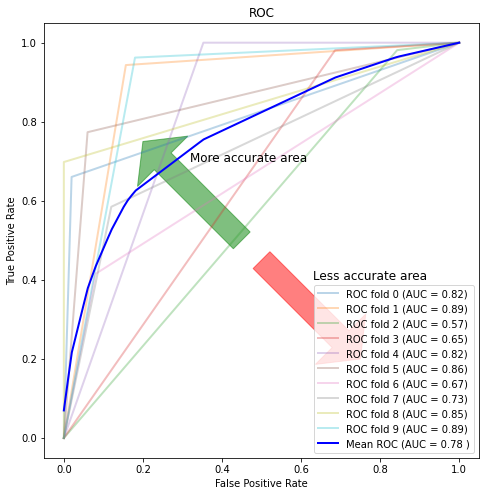

[0.7865168539325842, 0.9009009009009009, 0.7027027027027027, 0.7428571428571429, 0.8548387096774194, 0.8453608247422681, 0.5569620253164558, 0.6888888888888889, 0.8222222222222222]
0.7668055856933983
Avg_test_acc:  0.8405619865571323
Avg_test_sens:  0.8
Avg_test_spec:  0.7501176470588236


In [ ]:

batch_size = 64
f1_score=[]
num_epochs = 30

p_fold=10
crossval_res_kol=[]
# y_arr = np.array([get_label(f) for f in flist])
flist = np.array(sorted(flist))

kk=0 

fig1 = plt.figure(figsize=[8,8])
ax1 = fig1.add_subplot(111,aspect = 'equal')
ax1.add_patch(
    patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
    )
ax1.add_patch(
    patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
    )

tprs = []
aucs = []
overall_result=[]
mean_fpr = np.linspace(0,1,100)
z=0

kf = StratifiedKFold(n_splits=p_fold, random_state=1, shuffle=True)
np.random.seed(3)
np.random.shuffle(flist)
y_arr = np.array([get_label(f) for f in flist])
# print("K-Fold",kf)

avg_acc=[]
acc_avg=[]
sens_avg=[]
spec_avg=[]
tprs = []
aucs = []
true_all, pred_all, pred_proba = [], [], []
num_latent=[]
start=time.time()
for kk,(train_index, test_index) in enumerate(kf.split(flist, y_arr)):
    # print("in main", kk)
    train_samples, test_samples = flist[train_index], flist[test_index]
    # print(train_samples)
    train_loader=get_loader(data=all_corr_mat, samples_list=train_samples, 
                            batch_size=batch_size, mode='train')

    test_loader=get_loader(data=all_corr_mat, samples_list=test_samples, 
                           batch_size=batch_size, mode='test')
    
    model=convnet(num_inputs=9950)
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr = 0.06)
    print('k_fold:', kk )
    
    best_acc,best_sen,best_spec,j = 0.0,0.0,0.0, 0
    best_true,best_pred, best_proba = [],[],[]


    for epoch in range(1, num_epochs+1):
        print('epoch: ', epoch)

        train_losses = train(model, epoch, train_loader)
        acc, sens, spec,y_true,y_pred, y_proba = test(model, test_loader)
        # print(y_pred)
        
        # print(classification_report(y_true,y_pred))

        
        j = j + 1  

        
        if acc > best_acc:
            best_acc = acc
            best_sen=sens
            best_spec=spec
            print("Model_updated")
            best_true = y_true
            best_pred = y_pred
            best_proba = y_proba
            
            file_name = 'best_ACC' + str(kk) + '.pth' 
            # torch.save(model,file_name)
            j = 0
            
        else:  ## early stopping
            print('patience', j)
        if j == 25:
          print('test_best_acc:', best_acc,"test_sen",best_sen,"best_spec",best_spec)
          break
    
        print('test_best_acc:', best_acc,"test_sen",best_sen,"best_spec",best_spec)    
    
    fpr,tpr,threshold=roc_curve(y_true,y_pred)
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (z, roc_auc))    
    ##Title and label
    z=z+1
    tprs.append(interp(mean_fpr, fpr, tpr))
        
    aucs.append(roc_auc)  
    print('BEST_ACC: ' + str(best_acc) + "&&" + "k-fold" + str(kk))
    f1_score.append(classification_report(y_true,y_pred,output_dict=True))
    avg_acc.append(best_acc)
    true_all.append(best_true)
    pred_all.append(best_pred)
    pred_proba.append(best_proba)
    acc_avg.append(acc)
    sens_avg.append(sens)
    spec_avg.append(spec)
print(time.time()-start)
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()
a=[]
for i in range(0,9):
  a.append(f1_score[i]['1']['f1-score'])
print(a)
print(statistics.mean(a))
    
print('Avg_test_acc: ', np.mean(avg_acc))
print('Avg_test_sens: ', np.mean(sens_avg))
print('Avg_test_spec: ', np.mean(spec_avg))


In [ ]:
avg_acc

[0.8173076923076923,
 0.8942307692307693,
 0.7403846153846154,
 0.8461538461538461,
 0.9230769230769231,
 0.8543689320388349,
 0.7669902912621359,
 0.7281553398058253,
 0.941747572815534,
 0.8932038834951457]

In [ ]:
sens_avg

[0.660377358490566,
 0.9433962264150944,
 0.9811320754716981,
 0.9811320754716981,
 1.0,
 0.7735849056603774,
 0.41509433962264153,
 0.5849056603773585,
 0.6981132075471698,
 0.9622641509433962]

In [ ]:
spec_avg

[0.9803921568627451,
 0.8431372549019608,
 0.1568627450980392,
 0.3137254901960784,
 0.6470588235294118,
 0.94,
 0.92,
 0.88,
 1.0,
 0.82]

In [ ]:
time.time()-start 

3558.3238253593445

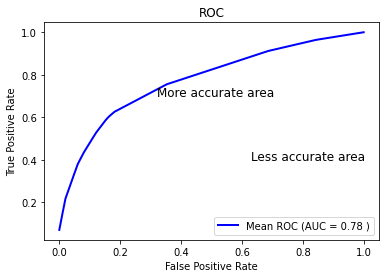

In [ ]:

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()


In [ ]:
avg_acc 
np.mean(avg_acc)
avg_acc



[0.8173076923076923,
 0.8942307692307693,
 0.7403846153846154,
 0.8461538461538461,
 0.9230769230769231,
 0.8543689320388349,
 0.7669902912621359,
 0.7281553398058253,
 0.941747572815534,
 0.8932038834951457]